In [1]:
# Filter and read in necessary dataframe from .csv

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Pre Processing
#df = pd.DataFrame()
#desired = 200000
#chunksize = 5000

# Reading the file in chunks
#for chunk in pd.read_csv('utd19_u.csv', chunksize=chunksize, low_memory=False):
#    chunk_bolton = chunk[chunk['city'] == "bolton"]
#    chunk_non_nan = chunk_bolton.dropna(subset=['speed', 'flow', 'occ', 'detid'])
#    df = pd.concat([df, chunk_non_nan], ignore_index=True)
#    if df.shape[0] >= desired:
#        print(f"Desired number of rows reached: {df.shape[0]}")
#        break

# Trim excess
#if df.shape[0] > desired:
#    df = df.head(desired)

# Final DataFrame size
#print(f"Final DataFrame size: {df.shape}")

# Save
#df.to_csv('filtered_data.csv', index=False)

# Read filtered csv
df = pd.read_csv('filtered_data.csv')
#df = df[['speed', 'flow', 'occ']]
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   day       200000 non-null  object 
 1   interval  200000 non-null  int64  
 2   detid     200000 non-null  object 
 3   flow      200000 non-null  float64
 4   occ       200000 non-null  float64
 5   error     158545 non-null  float64
 6   city      200000 non-null  object 
 7   speed     200000 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 12.2+ MB


In [ ]:
# Plotting to see what existing features look like on a 3D scatter plot, helps to figure out the feature engineering aspect

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['flow'], df['speed'], df['occ'], c='blue', marker='o', alpha=0.5)

ax.set_xlabel('Flow')
ax.set_ylabel('Speed')
ax.set_zlabel('Occupancy')
plt.title('3D Scatter Plot of Flow, Speed, and Occupancy')

plt.show()

In [ ]:
# Feature Engineering which shall be used for ALL of the implemented algorithms

from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Unique detector ids
det_ids = df['detid'].unique()

scaler = StandardScaler()
preprocessed_data = {}

# Features to scale
features_to_scale = ['speed','occ','flow','speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']

# Do for each det_id to account for differences in sensors
for det_id in det_ids:
    # Filter data for detector
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Handle zero speeds
    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps
    
    # Feature Engineering
    sensor_data['speed_inv'] = 1 / sensor_data['speed']
    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']

    # Check if all features have non-zero values
    non_zero_rows = (sensor_data[features_to_scale] != 0).any(axis=1)
    
    # Filter
    sensor_data = sensor_data[non_zero_rows]
    
    # Skip if empty
    if sensor_data.empty:
        continue

    # Scaling
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])

    # Store processed data
    preprocessed_data[det_id] = sensor_data

# Create unique identifier for each entry, needed for the Voting System implementation later
for det_id, sensor_data in preprocessed_data.items():
    sensor_data['unique_id'] = sensor_data.index.astype(str) + '_' + det_id

In [4]:
# Feature Engineering using PCA (only this cell or the one above should be used, not both!)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Constants
N_COMPONENTS = 0.95  # 95% variance
features_to_scale = ['speed', 'occ', 'flow', 'speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']

scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

det_ids = df['detid'].unique()
preprocessed_data = {}

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps  # Handle zero speeds

    # Feature Engineering
    sensor_data['speed_inv'] = 1 / sensor_data['speed']
    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']

    # Imputation and Scaling
    sensor_data[features_to_scale] = imputer.fit_transform(sensor_data[features_to_scale])
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])

    # Debugging and validation
    print("Data Descriptive Statistics for det_id", det_id)
    print(sensor_data[features_to_scale].describe())
    
    print("Checking for NaN or infinite values after scaling:")
    print("NaN count:", sensor_data[features_to_scale].isna().sum())
    print("Infinite count:", np.isinf(sensor_data[features_to_scale]).sum())

    variances = sensor_data[features_to_scale].var()
    print("Variance of features:", variances)

    # Ensure enough samples relative to dimensions
    if sensor_data.shape[0] < len(features_to_scale):
        print(f"Skipping PCA for {det_id} due to insufficient samples compared to dimensions.")
        continue

    # Ensure variances non-zero
    if any(variances == 0):
        print(f"Skipping PCA for {det_id} due to zero variance found in features.")
        continue

    # Apply PCA
    try:
        pca = PCA(n_components=N_COMPONENTS)
        principal_components = pca.fit_transform(sensor_data[features_to_scale])
        print(f"PCA applied successfully for {det_id}. Explained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")
        
        principal_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
        sensor_data = pd.concat([sensor_data.reset_index(drop=True), principal_df], axis=1)

        preprocessed_data[det_id] = sensor_data

    except Exception as e:
        print(f"Failed to apply PCA for {det_id} due to {e}.")
        #preprocessed_data[det_id] = sensor_data[features_to_scale]

# Create unique identifier for each entry, needed for the Voting System implementation later
for det_id, sensor_data in preprocessed_data.items():
    sensor_data['unique_id'] = sensor_data.index.astype(str) + '_' + det_id

Data Descriptive Statistics for det_id N51141G
        speed     occ    flow     speed_inv  flow_speed_ratio  occupancy_flow  \
count  1257.0  1257.0  1257.0  1.257000e+03            1257.0          1257.0   
mean      0.0     0.0     0.0  1.387779e-17               0.0             0.0   
std       0.0     0.0     0.0  0.000000e+00               0.0             0.0   
min       0.0     0.0     0.0  1.387779e-17               0.0             0.0   
25%       0.0     0.0     0.0  1.387779e-17               0.0             0.0   
50%       0.0     0.0     0.0  1.387779e-17               0.0             0.0   
75%       0.0     0.0     0.0  1.387779e-17               0.0             0.0   
max       0.0     0.0     0.0  1.387779e-17               0.0             0.0   

       speed_occupancy  weighted_occupancy  
count           1257.0              1257.0  
mean               0.0                 0.0  
std                0.0                 0.0  
min                0.0                 0.0 

anomaly
 1    74979
-1     2887
Name: count, dtype: int64


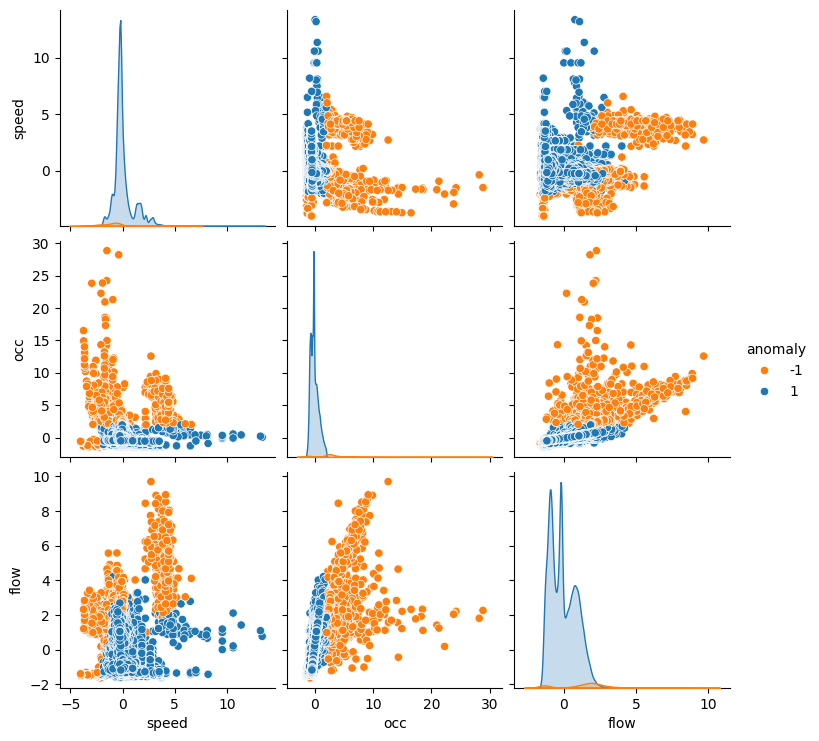

In [34]:
# Statistical Threshold for Labelling using non Feature Engineered values

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_df = pd.concat(preprocessed_data.values(), ignore_index=True)

# Calculate thresholds
def get_thresholds(df, feature, z_threshold=3):
    mean = df[feature].mean()
    std = df[feature].std()
    lower = mean - z_threshold * std
    upper = mean + z_threshold * std
    return lower, upper

# Smaller Z-score multiplier for more sensitivity towards anomaly detection
z_multiplier = 2.0

# Get thresholds with adjusted multiplier
speed_lower, speed_upper = get_thresholds(combined_df, 'speed', z_multiplier)
occ_lower, occ_upper = get_thresholds(combined_df, 'occ', z_multiplier)
flow_lower, flow_upper = get_thresholds(combined_df, 'flow', z_multiplier)

# Label anomalies
def label_congestion(row):
    if row['speed'] < speed_lower or row['occ'] > occ_upper or row['flow'] < flow_lower:
        return -1  # Congestion
    return 1  # Normal

combined_df['anomaly'] = combined_df.apply(label_congestion, axis=1)

# Display count of anomalies vs normal
print(combined_df['anomaly'].value_counts())

# Visualize
features_to_visualize = ['speed', 'occ', 'flow']
palette = {1: '#1f77b4', -1: '#ff7f0e'}  # Blue for normal, orange for anomalies

sns.pairplot(combined_df, vars=features_to_visualize, hue='anomaly', palette=palette)
plt.show()



anomaly
 1    74913
-1     2953
Name: count, dtype: int64


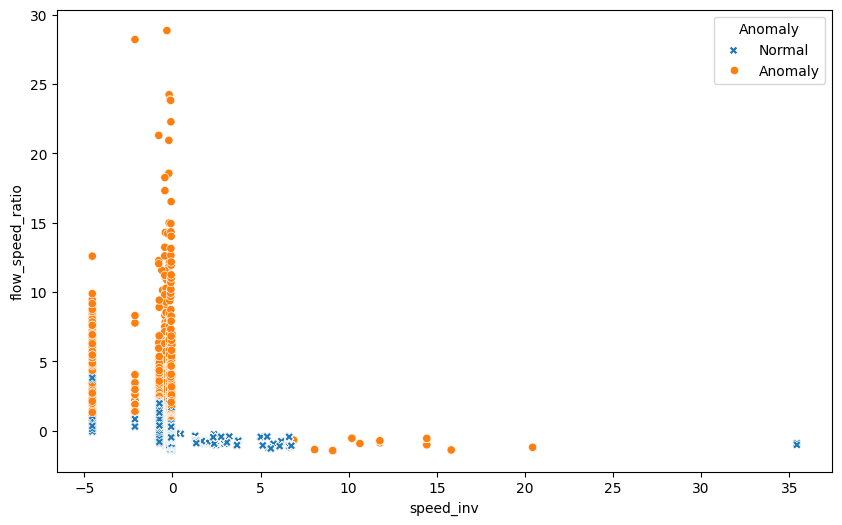

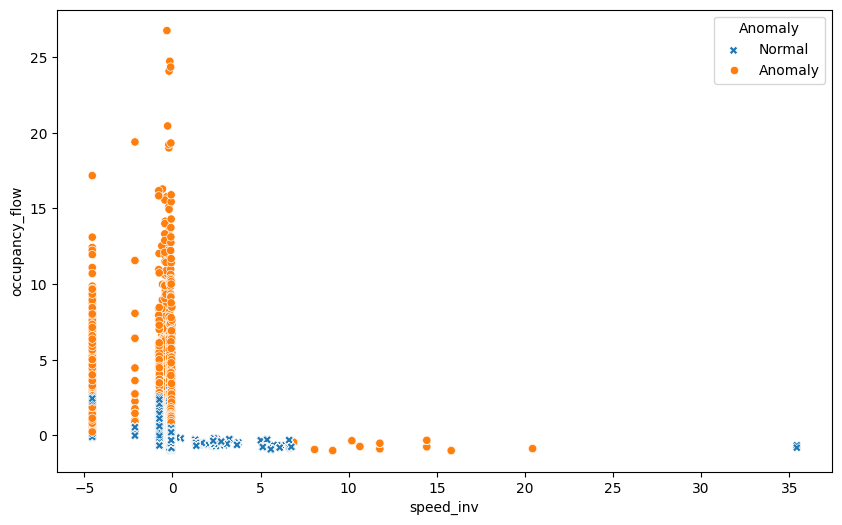

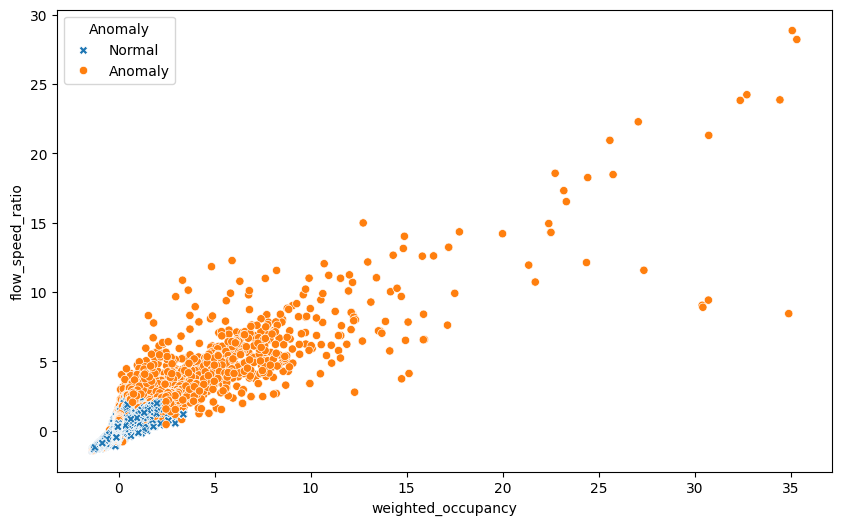

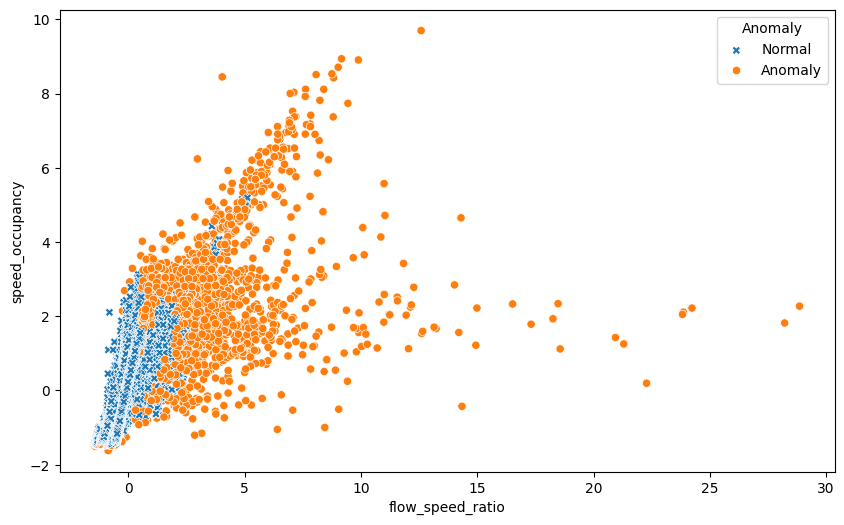

In [44]:
# Implementation of the Isolation Forest Anomaly Detection Algorithm

from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

combined_results_IF = pd.DataFrame()
sensor_models = {}

# Loop through det_ids and train model
for det_id in preprocessed_data:
    sensor_data = preprocessed_data[det_id]
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']

    # Train model
    clf = IsolationForest(contamination=0.04, random_state=42)
    clf.fit(sensor_data[features_to_scale])

    # Store model
    sensor_models[det_id] = clf

    # Anomaly score and label
    sensor_data['anomaly_score'] = clf.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = clf.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results_IF = pd.concat([combined_results_IF, sensor_data], ignore_index=True)

# Display count
print(combined_results_IF['anomaly'].value_counts())

# Display results
#palette = ['#ff7f0e', '#1f77b4']  # Orange for normal, blue for anomalies
#sns.pairplot(combined_results_IF, vars=features_to_scale, hue='anomaly', palette=palette)

#plt.show()

# Define the specific plots to extract
plot_features = [
    ('speed_inv', 'flow_speed_ratio'),
    ('speed_inv', 'occupancy_flow'),
    ('weighted_occupancy', 'flow_speed_ratio'),
    ('flow_speed_ratio', 'speed_occupancy')
]

# Create plots
for x, y in plot_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, hue='anomaly', style='anomaly', palette=palette, data=combined_results_IF)
    plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
    plt.show()


In [ ]:
from sklearn.svm import OneClassSVM
import numpy as np

# Assuming your combined data setup
combined_results_OCSVM = pd.DataFrame()
sensor_models = {}

nu = 0.05  # Target nu value

# Define other parameter grids
degrees = [2, 3, 4, 5, 6, 7, 8, 9, 10]
gammas = ['scale', 0.1, 0.01]
coef0s = [0, 1, 5, 10, 15, 20]

for det_id in preprocessed_data:
    sensor_data = preprocessed_data[det_id]
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
    
    # Calculate expected number of anomalies
    expected_anomalies = int(nu * len(sensor_data))
    tolerance_range = (0.045 * len(sensor_data), 0.055 * len(sensor_data))  # 4.5% to 5.5% range

    closest_model = None
    closest_count = float('inf')
    closest_params = {}

    # Grid search within det_id
    for degree in degrees:
        for gamma in gammas:
            for coef0 in coef0s:
                svm = OneClassSVM(kernel='poly', degree=degree, gamma=gamma, coef0=coef0, nu=nu)
                svm.fit(sensor_data[features_to_scale])
                preds = svm.predict(sensor_data[features_to_scale])
                n_anomalies = (preds == -1).sum()

                # Check if the anomaly count is within the acceptable range
                if tolerance_range[0] <= n_anomalies <= tolerance_range[1]:
                    distance = abs(n_anomalies - expected_anomalies)
                    if distance < closest_count:
                        closest_count = distance
                        closest_model = svm
                        closest_params = {'degree': degree, 'gamma': gamma, 'coef0': coef0}

    # Store the closest model or handle case where no model was within tolerance
    if closest_model:
        sensor_models[det_id] = closest_model
        sensor_data['anomaly_score'] = closest_model.decision_function(sensor_data[features_to_scale])
        sensor_data['anomaly'] = closest_model.predict(sensor_data[features_to_scale])
        print(f"Det ID {det_id}: Closest model params {closest_params} with anomalies {closest_count}")
    else:
        #print(f"Det ID {det_id}: No model within tolerance range.")

    # Combine results
    combined_results_OCSVM = pd.concat([combined_results_OCSVM, sensor_data], ignore_index=True)


anomaly
 1    75024
-1     2842
Name: count, dtype: int64


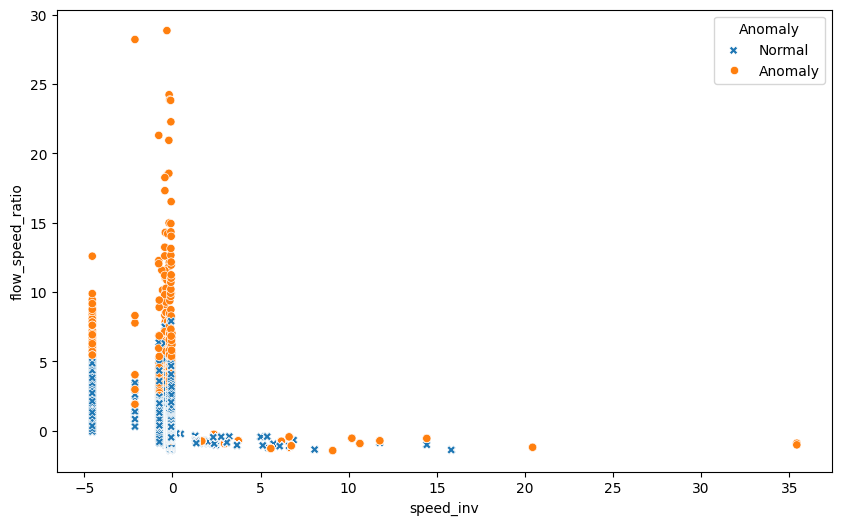

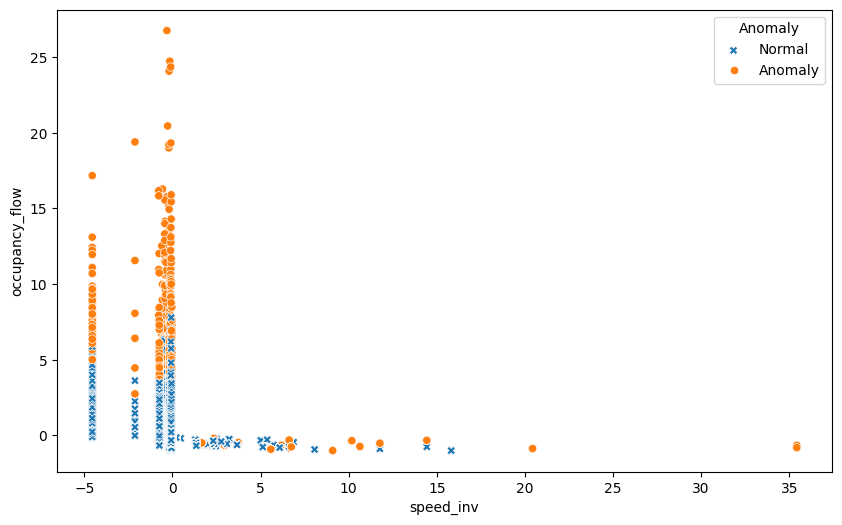

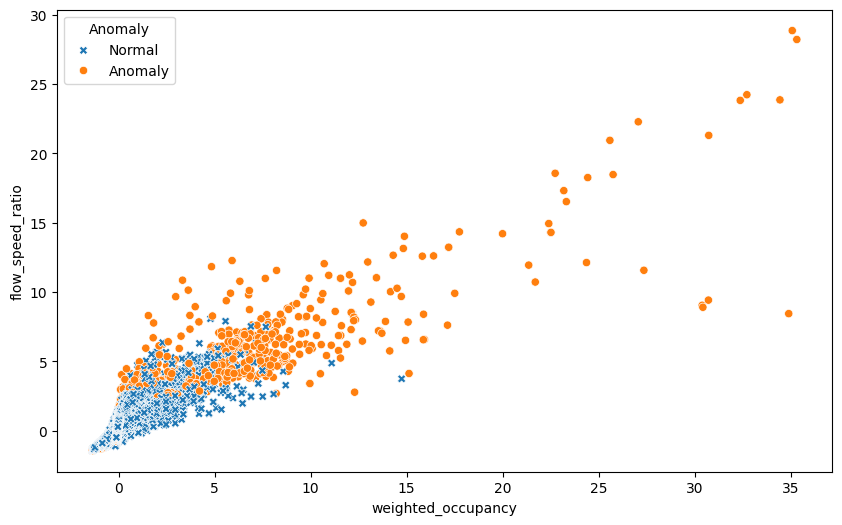

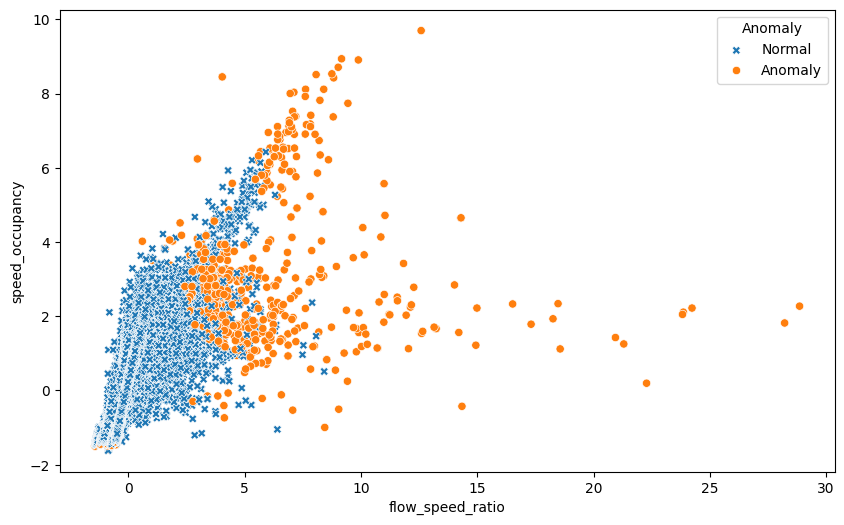

In [45]:
# OCSVM Implementation

from sklearn.svm import OneClassSVM

combined_results_OCSVM = pd.DataFrame()
sensor_models = {}

# Loop through det_ids and train model
for det_id in preprocessed_data:
    sensor_data = preprocessed_data[det_id]
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
    #features_to_scale = ['speed', 'flow', 'occ']
    
    # Train model
    #svm = OneClassSVM(kernel='poly', degree=2, gamma=0.15, coef0=10, nu=0.995)
    #svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.0001)
    svm = OneClassSVM(kernel='poly', degree=2, gamma='scale', coef0=10, nu=0.989)
    svm.fit(sensor_data[features_to_scale])

    sensor_models[det_id] = svm

    # Anomaly score and label
    sensor_data['anomaly_score'] = svm.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = svm.predict(sensor_data[features_to_scale])
    sensor_data['anomaly'] = sensor_data['anomaly'].apply(lambda x: -1 if x == 1 else 1)

    # Combine results into one dataframe
    combined_results_OCSVM = pd.concat([combined_results_OCSVM, sensor_data], ignore_index=True)

# Display count
print(combined_results_OCSVM['anomaly'].value_counts())

# Display combined results
#palette = ['#ff7f0e', '#1f77b4']
#sns.pairplot(combined_results_OCSVM, vars=features_to_scale, hue='anomaly', palette=palette)

#plt.show()

palette = {1: '#1f77b4', -1: '#ff7f0e'}  # Normal: Blue, Anomaly: Orange
plot_features = [
    ('speed_inv', 'flow_speed_ratio'),
    ('speed_inv', 'occupancy_flow'),
    ('weighted_occupancy', 'flow_speed_ratio'),
    ('flow_speed_ratio', 'speed_occupancy')
]

for x, y in plot_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, hue='anomaly', style='anomaly', data=combined_results_OCSVM, palette=palette)
    plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
    plt.show()

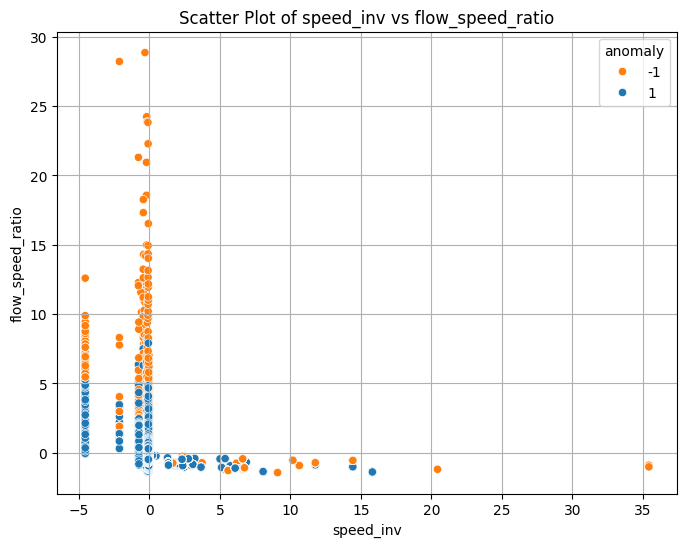

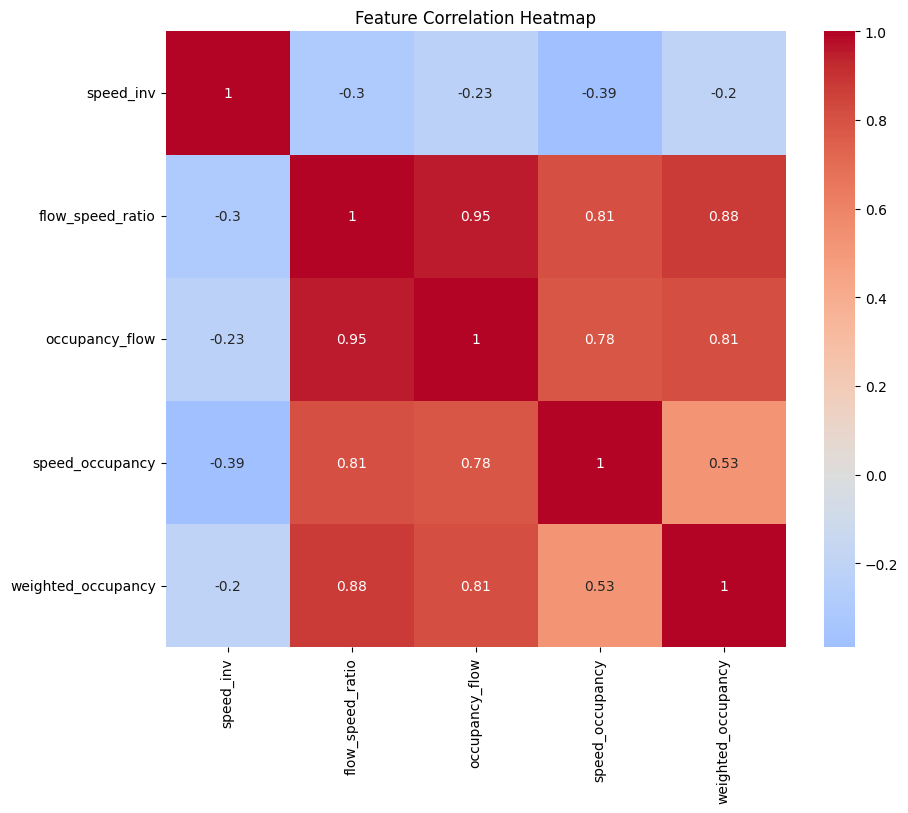

In [43]:
# Plot out for better representation of OCSVM

import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of two key features
def plot_scatter(df, x_feature, y_feature, hue_feature='anomaly', palette=['#ff7f0e', '#1f77b4']):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x_feature, y=y_feature, hue=hue_feature, palette=palette)
    plt.title(f'Scatter Plot of {x_feature} vs {y_feature}')
    plt.grid(True)
    plt.show()

# Plot a heatmap of correlations between features
def plot_heatmap(df, features):
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()

# Scatter Plot Example
plot_scatter(combined_results_OCSVM, 'speed_inv', 'flow_speed_ratio')

# Heatmap Example (Adjust feature list as needed)
features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
plot_heatmap(combined_results_OCSVM, features_to_scale)


In [ ]:
# Optimize DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Grid search parameters
eps_values = np.arange(0.1, 1.1, 0.1)
min_samples_values = range(2, 10)

# Store best parameters
global_best_params = {}
global_best_db_index = np.inf
global_best_ch_index = -1

for det_id in preprocessed_data:
    sensor_data = preprocessed_data[det_id]
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']

    # Local best for current detector
    best_db_index = np.inf
    best_ch_index = -1
    best_params = {}

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(sensor_data[features_to_scale])
            if len(set(labels)) - (1 if -1 in labels else 0) > 1:
                try:
                    db_index = davies_bouldin_score(sensor_data[features_to_scale], labels)
                    ch_index = calinski_harabasz_score(sensor_data[features_to_scale], labels)
                    if db_index < best_db_index:
                        best_db_index = db_index
                        best_params['db_index'] = db_index
                        best_params['eps_db'] = eps
                        best_params['min_samples_db'] = min_samples
                    if ch_index > best_ch_index:
                        best_ch_index = ch_index
                        best_params['ch_index'] = ch_index
                        best_params['eps_ch'] = eps
                        best_params['min_samples_ch'] = min_samples
                except ValueError as e:
                    continue

    # Update global best parameters
    if best_db_index < global_best_db_index:
        global_best_db_index = best_db_index
        global_best_params['eps_db'] = best_params['eps_db']
        global_best_params['min_samples_db'] = best_params['min_samples_db']

    if best_ch_index > global_best_ch_index:
        global_best_ch_index = best_ch_index
        global_best_params['eps_ch'] = best_params['eps_ch']
        global_best_params['min_samples_ch'] = best_params['min_samples_ch']

# After processing all detectors
print(f"Global Best DB Index Parameters: EPS: {global_best_params.get('eps_db')}, Min Samples: {global_best_params.get('min_samples_db')}")
print(f"Global Best CH Index Parameters: EPS: {global_best_params.get('eps_ch')}, Min Samples: {global_best_params.get('min_samples_ch')}")

anomaly
 1    75094
-1     2772
Name: count, dtype: int64


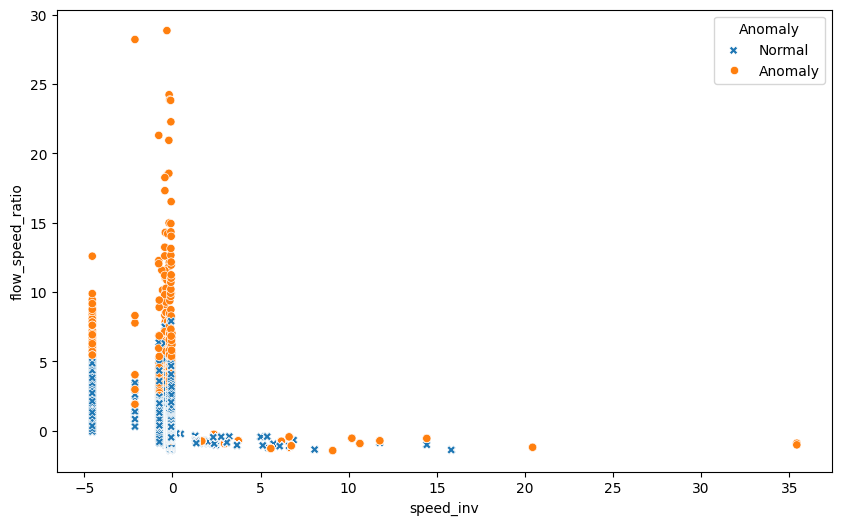

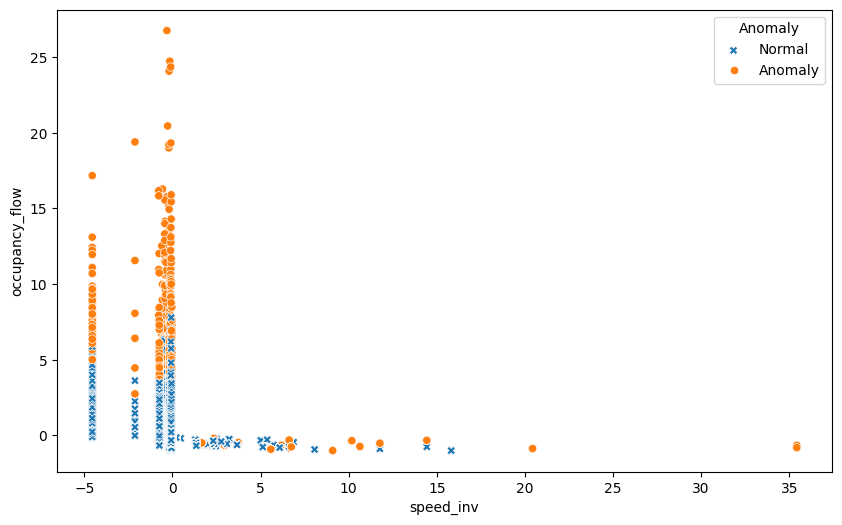

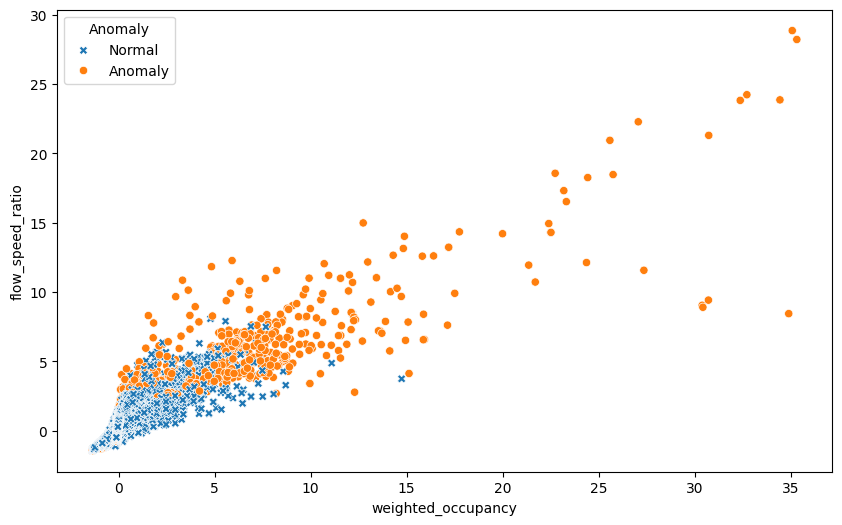

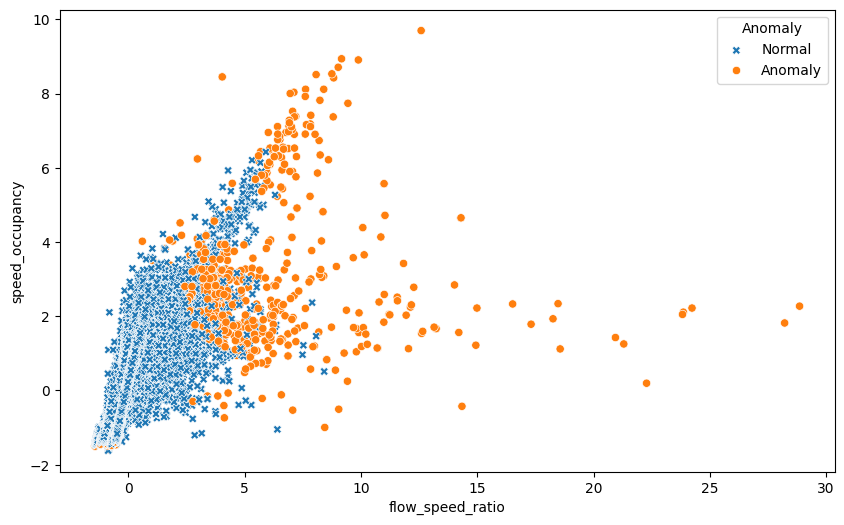

In [46]:
# DBSCAN Implementation

from sklearn.cluster import DBSCAN

# Dataset
combined_results_DBSCAN = pd.DataFrame()
sensor_models = {}

for det_id in preprocessed_data:
    sensor_data = preprocessed_data[det_id]
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
    
    # DBSCAN
    dbscan = DBSCAN(eps=0.15, min_samples=2) #Adjusted params based on previous optimization
    sensor_data['clusters'] = dbscan.fit_predict(sensor_data[features_to_scale])
    
    # Detect anomalies
    sensor_data['anomaly'] = sensor_data['clusters'].apply(lambda x: -1 if x == -1 else 1)
    
    # Store model and results
    sensor_models[det_id] = dbscan
    combined_results_DBSCAN = pd.concat([combined_results_DBSCAN, sensor_data], ignore_index=True)

# Display count
print(combined_results_DBSCAN['anomaly'].value_counts())

# Display combined results
#palette = ['#ff7f0e', '#1f77b4']  # Orange for normal, blue for anomalies
#sns.pairplot(combined_results_DBSCAN, vars=features_to_scale, hue='anomaly', palette=palette)
#plt.show()

palette = {1: '#1f77b4', -1: '#ff7f0e'}  # Normal: Blue, Anomaly: Orange
plot_features = [
    ('speed_inv', 'flow_speed_ratio'),
    ('speed_inv', 'occupancy_flow'),
    ('weighted_occupancy', 'flow_speed_ratio'),
    ('flow_speed_ratio', 'speed_occupancy')
]

for x, y in plot_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, hue='anomaly', style='anomaly', data=combined_results_OCSVM, palette=palette)
    plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
    plt.show()

In [48]:
# Voting System using the Consensus Method to determine accuracy

# Rename for further merge
combined_results_IF = combined_results_IF.rename(columns={'anomaly': 'anomaly_IF'})
combined_results_OCSVM = combined_results_OCSVM.rename(columns={'anomaly': 'anomaly_OCSVM'})
combined_results_DBSCAN = combined_results_DBSCAN.rename(columns={'anomaly': 'anomaly_DBSCAN'})

# Merge based on the index or a shared identifier
results_merged = pd.merge(combined_results_IF[['unique_id', 'anomaly_IF']], combined_results_OCSVM[['unique_id', 'anomaly_OCSVM']],
                          on='unique_id', how='inner')
results_merged = pd.merge(results_merged, combined_results_DBSCAN[['unique_id', 'anomaly_DBSCAN']], on='unique_id', how='inner')

# Apply Consensus Rule / Voting System
results_merged['consensus_anomaly'] = results_merged.apply(
    lambda row: -1 if (row['anomaly_IF'] == -1) + (row['anomaly_OCSVM'] == -1) + (row['anomaly_DBSCAN'] == -1) >= 2 else 1,
    axis=1
)

#Evaluation
from sklearn.metrics import classification_report

print("Isolation Forest vs. Consensus:")
print(classification_report(results_merged['consensus_anomaly'], results_merged['anomaly_IF'], target_names=['Normal', 'Anomaly']))

print("\nOne-Class SVM vs. Consensus:")
print(classification_report(results_merged['consensus_anomaly'], results_merged['anomaly_OCSVM'], target_names=['Normal', 'Anomaly']))

print("\nDBSCAN vs. Consensus:")
print(classification_report(results_merged['consensus_anomaly'], results_merged['anomaly_DBSCAN'], target_names=['Normal', 'Anomaly']))

Isolation Forest vs. Consensus:
              precision    recall  f1-score   support

      Normal       0.64      1.00      0.78      1904
     Anomaly       1.00      0.99      0.99     75962

    accuracy                           0.99     77866
   macro avg       0.82      0.99      0.89     77866
weighted avg       0.99      0.99      0.99     77866


One-Class SVM vs. Consensus:
              precision    recall  f1-score   support

      Normal       0.27      0.40      0.32      1904
     Anomaly       0.98      0.97      0.98     75962

    accuracy                           0.96     77866
   macro avg       0.63      0.69      0.65     77866
weighted avg       0.97      0.96      0.96     77866


DBSCAN vs. Consensus:
              precision    recall  f1-score   support

      Normal       0.61      0.88      0.72      1904
     Anomaly       1.00      0.99      0.99     75962

    accuracy                           0.98     77866
   macro avg       0.80      0.93      0.85

In [49]:
# Measuring Accuracy based on Statistical labelling

combined_df = combined_df.rename(columns={'anomaly': 'anomaly_statistical'})

# Merge
results_merged = pd.merge(combined_results_IF[['unique_id', 'anomaly_IF']],
                          combined_results_OCSVM[['unique_id', 'anomaly_OCSVM']], on='unique_id', how='inner')
results_merged = pd.merge(results_merged, combined_results_DBSCAN[['unique_id', 'anomaly_DBSCAN']], on='unique_id', how='inner')
results_merged = pd.merge(results_merged, combined_df[['unique_id', 'anomaly_statistical']], on='unique_id', how='inner')

# Evaluate Isolation Forest vs. Statistical Threshold
print("Isolation Forest vs. Statistical Threshold:")
print(classification_report(results_merged['anomaly_statistical'], results_merged['anomaly_IF'], target_names=['Normal', 'Anomaly']))

# Evaluate One-Class SVM vs. Statistical Threshold
print("\nOne-Class SVM vs. Statistical Threshold:")
print(classification_report(results_merged['anomaly_statistical'], results_merged['anomaly_OCSVM'], target_names=['Normal', 'Anomaly']))

# Evaluate DBSCAN vs. Statistical Threshold
print("\nDBSCAN vs. Statistical Threshold:")
print(classification_report(results_merged['anomaly_statistical'], results_merged['anomaly_DBSCAN'], target_names=['Normal', 'Anomaly']))


Isolation Forest vs. Statistical Threshold:
              precision    recall  f1-score   support

      Normal       0.72      0.73      0.73      2887
     Anomaly       0.99      0.99      0.99     74979

    accuracy                           0.98     77866
   macro avg       0.85      0.86      0.86     77866
weighted avg       0.98      0.98      0.98     77866


One-Class SVM vs. Statistical Threshold:
              precision    recall  f1-score   support

      Normal       0.29      0.28      0.28      2887
     Anomaly       0.97      0.97      0.97     74979

    accuracy                           0.95     77866
   macro avg       0.63      0.63      0.63     77866
weighted avg       0.95      0.95      0.95     77866


DBSCAN vs. Statistical Threshold:
              precision    recall  f1-score   support

      Normal       0.54      0.52      0.53      2887
     Anomaly       0.98      0.98      0.98     74979

    accuracy                           0.97     77866
   macr

In [ ]:
# Final Verdict

print("Isolation Forest vs. Statistical Threshold:")
report_if_stat = classification_report(results_combined['anomaly_statistical'], results_combined['anomaly_IF'], target_names=['Normal', 'Anomaly'], output_dict=True)
print(classification_report(results_combined['anomaly_statistical'], results_combined['anomaly_IF'], target_names=['Normal', 'Anomaly']))

print("\nIsolation Forest vs. Consensus:")
report_if_consensus = classification_report(results_combined['consensus_anomaly'], results_combined['anomaly_IF'], target_names=['Normal', 'Anomaly'], output_dict=True)
print(classification_report(results_combined['consensus_anomaly'], results_combined['anomaly_IF'], target_names=['Normal', 'Anomaly']))

# One-Class SVM vs. Statistical and Consensus
print("\nOne-Class SVM vs. Statistical Threshold:")
report_ocsvm_stat = classification_report(results_combined['anomaly_statistical'], results_combined['anomaly_OCSVM'], target_names=['Normal', 'Anomaly'], output_dict=True)
print(classification_report(results_combined['anomaly_statistical'], results_combined['anomaly_OCSVM'], target_names=['Normal', 'Anomaly']))

print("\nOne-Class SVM vs. Consensus:")
report_ocsvm_consensus = classification_report(results_combined['consensus_anomaly'], results_combined['anomaly_OCSVM'], target_names=['Normal', 'Anomaly'], output_dict=True)
print(classification_report(results_combined['consensus_anomaly'], results_combined['anomaly_OCSVM'], target_names=['Normal', 'Anomaly']))

# DBSCAN vs. Statistical and Consensus
print("\nDBSCAN vs. Statistical Threshold:")
report_dbscan_stat = classification_report(results_combined['anomaly_statistical'], results_combined['anomaly_DBSCAN'], target_names=['Normal', 'Anomaly'], output_dict=True)
print(classification_report(results_combined['anomaly_statistical'], results_combined['anomaly_DBSCAN'], target_names=['Normal', 'Anomaly']))

print("\nDBSCAN vs. Consensus:")
report_dbscan_consensus = classification_report(results_combined['consensus_anomaly'], results_combined['anomaly_DBSCAN'], target_names=['Normal', 'Anomaly'], output_dict=True)
print(classification_report(results_combined['consensus_anomaly'], results_combined['anomaly_DBSCAN'], target_names=['Normal', 'Anomaly']))


# Summarize average F1 score
def calculate_average_f1(report_stat, report_consensus):
    f1_stat = (report_stat['Normal']['f1-score'] + report_stat['Anomaly']['f1-score']) / 2
    f1_consensus = (report_consensus['Normal']['f1-score'] + report_consensus['Anomaly']['f1-score']) / 2
    return (f1_stat + f1_consensus) / 2

# Calculate average F1 score
average_f1_if = calculate_average_f1(report_if_stat, report_if_consensus)
average_f1_ocsvm = calculate_average_f1(report_ocsvm_stat, report_ocsvm_consensus)
average_f1_dbscan = calculate_average_f1(report_dbscan_stat, report_dbscan_consensus)

final_scores = {
    'Isolation Forest': average_f1_if,
    'One-Class SVM': average_f1_ocsvm,
    'DBSCAN': average_f1_dbscan
}

best_model = max(final_scores, key=final_scores.get)
print(f"The best anomaly detection model is {best_model} with an average F1 score of {final_scores[best_model]:.2f}.")

In [50]:
# Visualization of Results using Confusion Matrix Heatmaps

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Isolation Forest vs. Consensus
cm_if = confusion_matrix(results_merged['consensus_anomaly'], results_merged['anomaly_IF'], labels=[-1, 1])
disp_if = ConfusionMatrixDisplay(confusion_matrix=cm_if, display_labels=['Anomaly', 'Normal'])
disp_if.plot(cmap='Blues')
plt.title('Isolation Forest vs. Consensus Confusion Matrix')
plt.show()

# One Class SVM vs. Consensus
cm_if = confusion_matrix(results_merged['consensus_anomaly'], results_merged['anomaly_OCSVM'], labels=[-1, 1])
disp_if = ConfusionMatrixDisplay(confusion_matrix=cm_if, display_labels=['Anomaly', 'Normal'])
disp_if.plot(cmap='Blues')
plt.title('One Class SVM vs. Consensus Confusion Matrix')
plt.show()


# DBSCAN vs. Consensus
cm_if = confusion_matrix(results_merged['consensus_anomaly'], results_merged['anomaly_DBSCAN'], labels=[-1, 1])
disp_if = ConfusionMatrixDisplay(confusion_matrix=cm_if, display_labels=['Anomaly', 'Normal'])
disp_if.plot(cmap='Blues')
plt.title('DBSCAN vs. Consensus Confusion Matrix')
plt.show()

KeyError: 'consensus_anomaly'

In [51]:
# Visualization of Results using Precision Recall & ROC Curve

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay

# Isolation Forest vs. Consensus
y_true = results_merged['consensus_anomaly']
y_pred = results_merged['anomaly_IF']

precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=-1)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('Isolation Forest Precision Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=-1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('Isolation Forest ROC Curve')
plt.show()

# One Class SVM vs. Consensus
y_true = results_merged['consensus_anomaly']
y_pred = results_merged['anomaly_OCSVM']

precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=-1)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('One Class SVM Precision Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=-1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('Isolation Forest ROC Curve')
plt.show()

# DBSCAN vs. Consensus
y_true = results_merged['consensus_anomaly']
y_pred = results_merged['anomaly_DBSCAN']

precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=-1)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('DBSCAN Precision Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=-1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('Isolation Forest ROC Curve')
plt.show()


KeyError: 'consensus_anomaly'

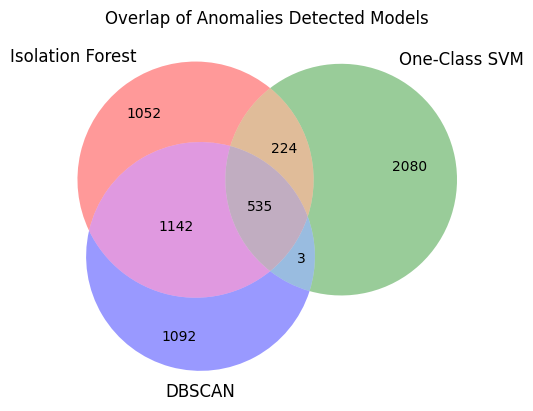

In [52]:
# Visualization of Results using Venn Diagram

from matplotlib_venn import venn3

# Anomalies to sets
set_if = set(results_merged[results_merged['anomaly_IF'] == -1]['unique_id'])
set_ocsvm = set(results_merged[results_merged['anomaly_OCSVM'] == -1]['unique_id'])
set_dbscan = set(results_merged[results_merged['anomaly_DBSCAN'] == -1]['unique_id'])

# Venn diagram
venn = venn3([set_if, set_ocsvm, set_dbscan], ('Isolation Forest', 'One-Class SVM', 'DBSCAN'))
plt.title('Overlap of Anomalies Detected Models')
plt.show()


In [ ]:
# Isolation Forest Plotting

features_to_plot = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='anomaly_IF', y=feature, data=combined_results_IF)
    plt.title(f'Box plot of {feature}')
    plt.show()

In [ ]:
# OCSVM Plotting

features_to_plot = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='anomaly_OCSVM', y=feature, data=combined_results_OCSVM)
    plt.title(f'Box plot of {feature}')
    plt.show()

In [ ]:
# DBSCAN Plotting

features_to_plot = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='anomaly_DBSCAN', y=feature, data=combined_results_DBSCAN)
    plt.title(f'Box plot of {feature}')
    plt.show()

In [ ]:
# Plotting of raw data without scaling

import pandas as pd
import numpy as np
import seaborn as sns

# Unique detector ids
det_ids = df['detid'].unique()

preprocessed_unscaled_data = {}

# Do for each det_id to account for differences in sensors
for det_id in det_ids:
    # Filter data for detector
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Handle zero speeds
    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps
    
    # Feature Engineering
    sensor_data['speed_inv'] = 1 / sensor_data['speed']
    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']

    # Store processed data
    preprocessed_unscaled_data[det_id] = sensor_data


In [ ]:
# Implementation of the Isolation Forest Anomaly Detection Algorithm without Scaling as an example to describe why the graphs sometimes look linearly separated

from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

combined_results = pd.DataFrame()
sensor_models = {}

# Loop through det_ids and train model
for det_id in preprocessed_unscaled_data:
    sensor_data = preprocessed_unscaled_data[det_id]
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']

    # Train model
    clf = IsolationForest(contamination=0.05, random_state=42)
    clf.fit(sensor_data[features_to_scale])

    # Store model
    sensor_models[det_id] = clf

    # Anomaly score and label
    sensor_data['anomaly_score'] = clf.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = clf.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display results
palette = ['#ff7f0e', '#1f77b4']  # Orange for normal, blue for anomalies
sns.pairplot(combined_results, vars=features_to_scale, hue='anomaly', palette=palette)

plt.show()

In [ ]:
# Isolation Forest without Feature Engineering as an example to display the importance of feature engineering

det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Scale features
    features_to_scale = ['speed', 'flow', 'occ']
    scaler = StandardScaler()
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])
    
    # Train model
    clf = IsolationForest(contamination=0.05, random_state=42)
    clf.fit(sensor_data[features_to_scale])

    sensor_models[det_id] = clf

    # Anomaly score and label
    sensor_data['anomaly_score'] = clf.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = clf.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display combined results
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(combined_results, vars=['speed', 'flow', 'occ'], hue='anomaly', palette=palette)

plt.show()